In [1]:
import tensorflow as tf

# setup a single GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
     # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')        
        gpu_config  = tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [gpu_config])
        
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
data_dir = "C:/Users/Andrea Torcianti/Maschinenbau/Udemy/Techlabs/project/data_7_classes"

In [4]:
#this code checks if the data is ok 
from pathlib import Path
import imghdr


image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [5]:
# Get a list of all the image files in the directory
#this works only with the full directory, not if the images are in the data folder
img_files = [os.path.join(data_dir, f) 
             for f in os.listdir(data_dir) if f.endswith('.jpg') or f.endswith('.png')]

In [6]:
#get the class names
class_names = os.listdir(data_dir)
print(class_names)

['apples', 'banana_peels', 'cardboard', 'glass_bottle', 'oranges', 'plastic_packaging', 'smartphone']


In [8]:
# Set the batch size and image size
batch_size = 16
img_size = (224, 224)

# Set the directory containing the images

# Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)


Found 258 files belonging to 7 classes.
Using 207 files for training.
Found 258 files belonging to 7 classes.
Using 51 files for validation.


In [9]:
val_ds.class_names

['apples',
 'banana_peels',
 'cardboard',
 'glass_bottle',
 'oranges',
 'plastic_packaging',
 'smartphone']

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


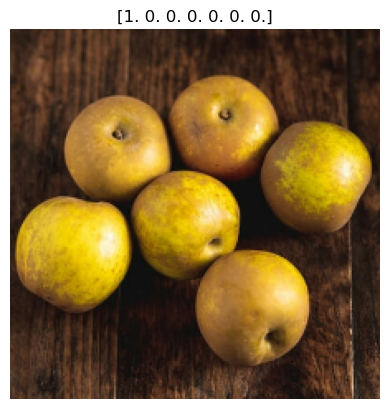

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Take the first batch of images and labels
for images, labels in train_ds.take(3):
    # Convert batch to NumPy array
    np_images = images.numpy()
    np_labels = labels.numpy()

# Plot the first image in the array
plt.imshow(np_images[0].astype('uint8'))
plt.axis('off')
plt.title(np_labels[0])
plt.show()


In [11]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))

In [12]:
#normalize the dataset
def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

In [14]:
#this seems to create problems 
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
tf.keras.layers.RandomRotation(factor=0.05, seed=42),
tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [32]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(labels.shape[1], activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [33]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_5')>

In [34]:
#freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
metrics=["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=4)

Epoch 1/4
13/13 [==============================] - 6s 299ms/step - loss: 1.3443 - accuracy: 0.5990 - val_loss: 0.7450 - val_accuracy: 0.9216
Epoch 2/4
13/13 [==============================] - 3s 238ms/step - loss: 0.4046 - accuracy: 0.9662 - val_loss: 0.3627 - val_accuracy: 0.9216
Epoch 3/4
13/13 [==============================] - 3s 238ms/step - loss: 0.1832 - accuracy: 0.9807 - val_loss: 0.2221 - val_accuracy: 0.9804
Epoch 4/4
13/13 [==============================] - 3s 239ms/step - loss: 0.1131 - accuracy: 0.9903 - val_loss: 0.1755 - val_accuracy: 0.9804


In [36]:
y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

cm = tf.math.confusion_matrix(y_true, y_pred)
print(cm)

1/1 [==============================] - 0s 32ms/step
tf.Tensor(
[[4 0 0 0 0 0 0]
 [0 8 0 0 0 0 0]
 [0 0 5 0 0 0 0]
 [0 0 0 8 0 0 0]
 [0 0 0 0 9 0 0]
 [0 0 1 0 0 8 0]
 [0 0 0 0 0 0 8]], shape=(7, 7), dtype=int32)
